In [1]:
from utils import *
import tensorflow as tf

import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.utils import np_utils        
from torch.utils.data import TensorDataset 


import os
import sympy as sp
from sympy import exp, sqrt, pi, Integral, Symbol
import time
from scipy.io import savemat


import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
seed_value = 0
set_seed(seed_value)

In [3]:
# make folder to save results
experiment_directory_name = '4ary'
if not os.path.isdir('./'+experiment_directory_name):
    os.mkdir('./'+experiment_directory_name)

In [4]:
# Generate Data

In [5]:
data_n = int(3e6)
sigma=1.0
nb_x_classes = 4
nb_z_classes = 4
transition_prob = 0.1

In [6]:
db = decision_boundary(nb_z_classes)
print(db)

[-3 -1  1  3]


In [7]:
a = sym_mat(nb_x_classes, transition_prob)
print(a)

[[0.9        0.03333333 0.03333333 0.03333333]
 [0.03333333 0.9        0.03333333 0.03333333]
 [0.03333333 0.03333333 0.9        0.03333333]
 [0.03333333 0.03333333 0.03333333 0.9       ]]


In [8]:
discrete_x_denoising = source_generator_v2(data_n, a)  
print(discrete_x_denoising[10:20])

[ 1  1  1  1  1  1 -3 -3 -3 -3]


In [9]:
noisy_y_denoising = np.round(con_noisy_awgn(discrete_x_denoising,sigma) , 2 ) # upto two decimal point
print(noisy_y_denoising[10:20])

[-0.12  0.51  2.24  1.49  1.84  0.58 -2.2  -3.68 -2.59 -2.99]


In [10]:
quantized_z_denoising = find_nearest_integer(noisy_y_denoising, nb_z_classes)
print(quantized_z_denoising[10:20])

[-1  1  3  1  1  1 -3 -3 -3 -3]


In [11]:
print(min(noisy_y_denoising))
print(max(noisy_y_denoising))

-7.8
7.62


In [12]:
print( 'Data length : ', len(discrete_x_denoising) )
error_x_z = error_rate(discrete_x_denoising, quantized_z_denoising)
print('error_rate(x vs z) : ' , error_x_z)

Data length :  3000000
error_rate(x vs z) :  0.23839433333333335


# Channel

In [13]:
# induced channel matrix

In [14]:
PI = np.zeros((nb_x_classes,nb_z_classes),dtype=float)
x = Symbol('x')
for i in range(nb_x_classes):
    f = sp.exp(-(x-(db[i]))**2/(2*((sigma)**2)))/(sigma*sp.sqrt(2*sp.pi))
    for j in range(nb_z_classes):
        if j == 0 :
            PI[i][j] = sp.Integral(f, (x, -float('inf'), db[0] + 1 )).doit().evalf()
            
        elif j == nb_z_classes-1:
            PI[i][j] = sp.Integral(f, (x, db[nb_z_classes-1] - 1, float('inf'))).doit().evalf()
            
        else :
            PI[i][j] = sp.Integral(f, (x, db[j]-1, db[j]+1 )).doit().evalf()
    print('proceeding..')
print(PI)

PI_inverse = np.linalg.inv(PI)
print(PI_inverse)

proceeding..
proceeding..
proceeding..
proceeding..
[[8.41344746e-01 1.57305356e-01 1.34961138e-03 2.86651572e-07]
 [1.58655254e-01 6.82689492e-01 1.57305356e-01 1.34989803e-03]
 [1.34989803e-03 1.57305356e-01 6.82689492e-01 1.58655254e-01]
 [2.86651572e-07 1.34961138e-03 1.57305356e-01 8.41344746e-01]]
[[ 1.2456367  -0.30320363  0.07034632 -0.0127794 ]
 [-0.30581077  1.62502643 -0.39018746  0.07097181]
 [ 0.07097181 -0.39018746  1.62502643 -0.30581077]
 [-0.0127794   0.07034632 -0.30320363  1.2456367 ]]


In [15]:
# pdf table

In [16]:
start = - (nb_z_classes-1)*10
print(start)
end = (nb_z_classes-1)*10
print(end)
interval_length = end - start
print(interval_length)

pdf_table = np.zeros((nb_x_classes , interval_length*100),dtype='float64') # interval : 0.01

for i in range(nb_x_classes):
    f = sp.exp(-(x-(db[i]))**2/(2*((sigma)**2)))/(sigma*sp.sqrt(2*sp.pi))
    f_ = f.evalf()
    
    for j in range(interval_length*100) :
        pdf_table[i][j] = f_.subs(x, start+(j)/100) # x에 0.00~9.99대입 
        
    print('proceeding..')
print(pdf_table.shape)
print(pdf_table)

-30
30
60
proceeding..
proceeding..
proceeding..
proceeding..
(4, 6000)
[[1.99788926e-159 2.61703305e-159 3.42770607e-159 ... 3.60845068e-237
  2.59484947e-237 1.86577871e-237]
 [9.55169454e-184 1.27645089e-183 1.70562819e-183 ... 2.11889749e-209
  1.55448749e-209 1.14030515e-209]
 [8.36395161e-210 1.14030515e-209 1.55448749e-209 ... 2.27887861e-183
  1.70562819e-183 1.27645089e-183]
 [1.34141967e-237 1.86577871e-237 2.59484947e-237 ... 4.48905069e-159
  3.42770607e-159 2.61703305e-159]]


In [17]:
print(min(noisy_y_denoising))
print(max(noisy_y_denoising))
print('Range :',start, -start)

-7.8
7.62
Range : -30 30


In [18]:
np.set_printoptions(linewidth=180)
print('PI :')
print(PI)

print('pdf_table :')
print(pdf_table)

PI :
[[8.41344746e-01 1.57305356e-01 1.34961138e-03 2.86651572e-07]
 [1.58655254e-01 6.82689492e-01 1.57305356e-01 1.34989803e-03]
 [1.34989803e-03 1.57305356e-01 6.82689492e-01 1.58655254e-01]
 [2.86651572e-07 1.34961138e-03 1.57305356e-01 8.41344746e-01]]
pdf_table :
[[1.99788926e-159 2.61703305e-159 3.42770607e-159 ... 3.60845068e-237 2.59484947e-237 1.86577871e-237]
 [9.55169454e-184 1.27645089e-183 1.70562819e-183 ... 2.11889749e-209 1.55448749e-209 1.14030515e-209]
 [8.36395161e-210 1.14030515e-209 1.55448749e-209 ... 2.27887861e-183 1.70562819e-183 1.27645089e-183]
 [1.34141967e-237 1.86577871e-237 2.59484947e-237 ... 4.48905069e-159 3.42770607e-159 2.61703305e-159]]


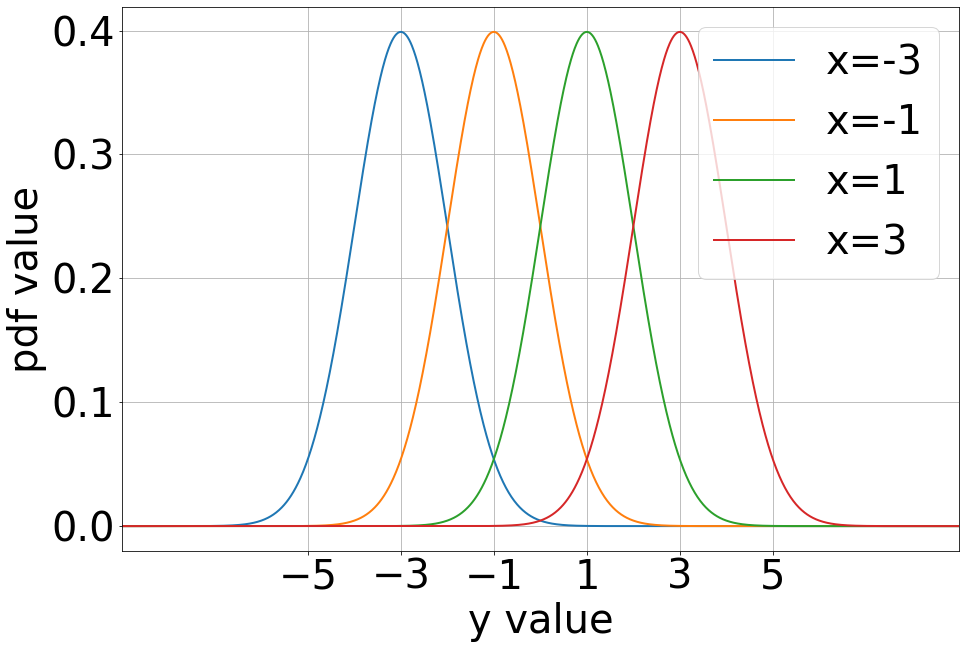

In [19]:
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid'] = True 
plt.rcParams['font.size'] = 40

x = np.arange(start,end,0.01) # -36.00 ~ 35.99 까지 ~~

y_0 = pdf_table[0]
y_1 = pdf_table[1]
y_2 = pdf_table[2]
y_3 = pdf_table[3]

plt.plot(x,y_0,label='x=-3') # A bar chart
plt.plot(x,y_1,label='x=-1') # A bar chart
plt.plot(x,y_2,label='x=1') # A bar chart
plt.plot(x,y_3,label='x=3') # A bar chart

#plt.title("pdf table made by picking points ")
plt.xlabel('y value')
plt.ylabel('pdf value')
plt.xticks([-5,-3,-1,1,3,5])
plt.legend(loc='upper right')
plt.xlim(-6+db[0],6+db[nb_z_classes-1])
plt.savefig("./"+experiment_directory_name+"/4ary_pdf_table_line.png", dpi = 100)

plt.show()


In [20]:
file_model = 'Gen-CUDE'
    
f = open('./'+experiment_directory_name+'/result_'+file_model+'.txt', 'w') 
f.flush()
f.flush()
f.close()   

In [21]:
batch_size = 1000
epochs = 10

In [22]:
loss_matrix = np.int_(np.ones((nb_x_classes, nb_x_classes)) - np.eye(nb_x_classes))
print(loss_matrix)

z=transform_to_narrow(quantized_z_denoising,nb_z_classes)
Z=np_utils.to_categorical(  z, nb_z_classes ,dtype=np.int32)

[[0 1 1 1]
 [1 0 1 1]
 [1 1 0 1]
 [1 1 1 0]]


In [23]:
k_set = []
error_set = []
time_set = []

for k in [1,2,3,5,8,10,15,20,30,50]:
    print('k',k)
    
    start_time = time.time()  
    ###################################################################################
    train_x = input_context_without_middle_symbol(noisy_y_denoising, k)
    train_y = Z[k:len(Z)-k,]
   

    y_middle = middle_y(noisy_y_denoising,k) 
    pdf_vector = p_vector_from_wide_pdf_table(y_middle, pdf_table, nb_x_classes, end)
    
    
    
    
    #----------------------------Neural Net model------------------------------#
    #inputs = layers.Input(shape = (2 * k * nb_z_classes,))  # one hot
    inputs = layers.Input(shape = (2 * k,))  # not one hot
    layer = layers.Dense(200, kernel_initializer = 'he_normal')(inputs)
    layer = layers.Activation('relu')(layer)
    layer = layers.Dense(200, kernel_initializer = 'he_normal')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Dense(200, kernel_initializer = 'he_normal')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Dense(200, kernel_initializer = 'he_normal')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Dense(200, kernel_initializer = 'he_normal')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Dense(200, kernel_initializer = 'he_normal')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Dense(nb_z_classes , kernel_initializer = 'he_normal')(layer)
    outputs = layers.Activation('softmax')(layer)
    model = models.Model(inputs = inputs, outputs = outputs)
    #--------------------------------------------------------------------------#
    
    adam = optimizers.Adam(lr=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=adam)


    
    model.fit(train_x,train_y,epochs=epochs,batch_size=batch_size,
                     verbose=1, validation_data=(train_x,train_y), shuffle=True)

    
    pred_prob = model.predict(train_x, batch_size = batch_size, verbose = 1)
    
    pred_prob_u_0 = pred_prob.dot(PI_inverse)
    new_target = pred_prob_u_0 * pdf_vector    
    denoised_seq = np.argmin(new_target.dot(loss_matrix),axis=1) 
    
    x_nn_hat_sub= transform_to_wide(denoised_seq, nb_x_classes)
    x_hat=np.hstack((quantized_z_denoising[0:k],x_nn_hat_sub,quantized_z_denoising[data_n - k:data_n]))
    ###############################################################################################
    
    duration = time.time() - start_time
    print("time(s)):", duration )  
    
    error_x_hat = error_rate(discrete_x_denoising,x_hat)
    print('x_hat_error : ', error_x_hat)

    
    ################################# save result ################################################ 
    f = open('./'+experiment_directory_name+'/result_'+file_model+'.txt', 'a')
    f.flush()
    PRINT(f, 'window size k : %d'%k)
    PRINT(f, 'time(s) : %f'%duration)
    f.flush()
    PRINT(f, 'x_hat_error_rate : %f'%error_x_hat)
    PRINT(f, '')

    f.flush()
    f.close()
    
    
    k_set.append(k)
    time_set.append(duration)
    error_set.append(error_x_hat)

k 1


W0601 10:12:33.911651 139781591783168 module_wrapper.py:139] From /compuworks/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0601 10:12:33.916858 139781591783168 module_wrapper.py:139] From /compuworks/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0601 10:12:33.924173 139781591783168 module_wrapper.py:139] From /compuworks/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0601 10:12:34.029192 139781591783168 module_wrapper.py:139] From /compuworks/anaconda3/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0601 10:12:34.037954

Train on 2999998 samples, validate on 2999998 samples
Epoch 1/10


W0601 10:12:35.749322 139781591783168 module_wrapper.py:139] From /compuworks/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W0601 10:12:35.751596 139781591783168 module_wrapper.py:139] From /compuworks/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:199: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.

W0601 10:12:35.940226 139781591783168 module_wrapper.py:139] From /compuworks/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:206: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



2999998/2999998 [==============================] - 44s 15us/step - loss: 0.8781 - val_loss: 0.8716
Epoch 2/10
2999998/2999998 [==============================] - 42s 14us/step - loss: 0.8697 - val_loss: 0.8712
Epoch 3/10
2999998/2999998 [==============================] - 43s 14us/step - loss: 0.8688 - val_loss: 0.8678
Epoch 4/10
2999998/2999998 [==============================] - 42s 14us/step - loss: 0.8682 - val_loss: 0.8676
Epoch 5/10
2999998/2999998 [==============================] - 42s 14us/step - loss: 0.8679 - val_loss: 0.8677
Epoch 6/10
2999998/2999998 [==============================] - 43s 14us/step - loss: 0.8677 - val_loss: 0.8671
Epoch 7/10
2999998/2999998 [==============================] - 43s 14us/step - loss: 0.8675 - val_loss: 0.8679
Epoch 8/10
2999998/2999998 [==============================] - 43s 14us/step - loss: 0.8674 - val_loss: 0.8671
Epoch 9/10
2999998/2999998 [==============================] - 43s 14us/step - loss: 0.8673 - val_loss: 0.8678
Epoch 10/10
2999998/2

In [21]:
saving_list = {'window_size_k':k_set, 'time':time_set, 'error_rate':error_set, 'error_x_z':error_x_z}
saving_list = dict(saving_list)
savemat('./'+experiment_directory_name+'/result_'+file_model+'.mat', saving_list)